## PermANOVA to test if topological metrics can distinguish between animals, stimuli, region, etc.

- tests if the topological structures diffrent significantly across the experimental factors

Author: @emilyekstrum
<br> 11/17/25

In [ ]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from persim.persistent_entropy import persistent_entropy
from scipy.stats import wasserstein_distance
from scipy import stats
from itertools import combinations

In [ ]:
data_dir = "/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/h2_dgms"  #directory to dgms

#organize by stimulus
stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "ce": "color_exchange",
    "lf": "luminance_flash",
}

def parse_filename(fname):
    """ Parse filename to get method, embed_dim, region, stim, mouse 
    
    Args:
        fname (str): filename

    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)
    parts = name.split("_")

    if len(parts) < 5:
        raise ValueError(f"Unexpected filename structure: {fname}")

    if fname.startswith("CEBRA"):
        method = parts[0]
        embed_dim = parts[1]   
        region = parts[2]      
        stim_code = parts[3]   
        mouse = parts[4]  

        stim = stim_map.get(stim_code, stim_code)

        return {
            "method": method,
            "embed_dim": embed_dim,
            "region": region,
            "stim": stim,
            "mouse": mouse,
        }
    else:
        raise ValueError(f"Unexpected filename structure: {fname}")

def load_dgms(path):
    """ Load diagrams from pickle file

    Args:
        path (str): path to pickle file

    Returns:
        list: list of diagrams"""

    with open(path, "rb") as f:
        dgms = pkl.load(f)
    return dgms

def entropy_from_dgms(dgms):
    """ Calculate persistence entropy from diagrams
    
    Args:
        dgms (list): list of diagrams

    Returns:
        list: list of tuples (homology label, entropy) """

    results = []
    for i, dgm in enumerate(dgms):
        homology_label = f"H{i}"
        if dgm is None or len(dgm) == 0:
            ent = np.nan
        else:
            ent_result = persistent_entropy(dgm)
            # get scalar value if result is an array
            if isinstance(ent_result, np.ndarray):
                ent = ent_result.item() if ent_result.size == 1 else ent_result[0]
            else:
                ent = ent_result
        results.append((homology_label, ent))
    return results

def wassserstain_distance(dgms):
    """ Calculate Wasserstein distance between diagrams
    
    Args:
        dgms (list): list of diagrams

    Returns:
        list: list of tuples (homology label, distance) """

    wasserstein_distances = []
    for i in range(len(dgms)):
        for j in range(i+1, len(dgms)):
            dgm1 = dgms[i]
            dgm2 = dgms[j]
            dist = wasserstein_distance(dgm1, dgm2)
            print(f"Wasserstein distance between H{i} and H{j}: {dist}")
            wasserstein_distances.append(dist)
    return wasserstein_distances


rows = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".pkl"):
        continue

    fpath = os.path.join(data_dir, fname)

    # parse filename (region, mouse, stim, dim)
    try:
        meta = parse_filename(fname)
    except ValueError as e:
        print(f"Skipping {fname}: {e}")
        continue

    # load diagrams
    dgms = load_dgms(fpath)

    # compute entropy per homology group
    homology_entropies = entropy_from_dgms(dgms)

    for homology_label, pent in homology_entropies:
        rows.append({
            "file": fname,
            "region": meta["region"],        # LGN / V1
            "mouse": meta["mouse"],          # C159
            "stim": meta["stim"],            # drifting_gratings, etc
            "embed_dim": meta["embed_dim"],  # 32d
            "homology": homology_label,      # H0, H1, H2 (from index)
            "persistence_entropy": pent,
        })

df = pd.DataFrame(rows)
df = df.dropna(subset=["persistence_entropy"]).reset_index(drop=True)

print("Data preview:")
print(df.head())
print("\nShape:", df.shape)
print("\nData types:")
print(df.dtypes)

formula = (
    "persistence_entropy ~ "
    "C(region) + C(mouse) + C(stim) + C(embed_dim) + C(homology)"
)

model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


def permutation_anova(df, formula, n_perm=999, random_state=0):
    """ Perform permutation ANOVA on the data
    
    Args:
        df (pd.DataFrame): dataframe containing the data
        formula (str): formula for the ANOVA
        n_perm (int): number of permutations

    Returns:
        pd.DataFrame: dataframe containing the permutation ANOVA results """
    
    rng = np.random.default_rng(random_state)

    # observed
    base_model = ols(formula, data=df).fit()
    base_anova = sm.stats.anova_lm(base_model, typ=2)
    obs_F = base_anova["F"].to_dict()

    # to store permuted F
    perm_F = {term: [] for term in obs_F if term != "Residual"}

    y = df["persistence_entropy"].to_numpy().copy()

    for _ in range(n_perm):
        rng.shuffle(y)
        df_perm = df.copy()
        df_perm["persistence_entropy"] = y
        m_perm = ols(formula, data=df_perm).fit()
        a_perm = sm.stats.anova_lm(m_perm, typ=2)

        for term in perm_F.keys():
            perm_F[term].append(a_perm.loc[term, "F"])

    # compute p-values
    out = base_anova.copy()
    out["perm_pval"] = np.nan
    for term, vals in perm_F.items():
        vals = np.array(vals)
        obs = obs_F[term]
        p = (np.sum(vals >= obs) + 1) / (len(vals) + 1)
        out.loc[term, "perm_pval"] = p

    return out


perm_results = permutation_anova(df, formula, n_perm=999, random_state=0)

# show results
print("\nPermutation ANOVA results:")
print(perm_results)


Skipping V1_32d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_32d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping V1_8d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_8d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping V1_3d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_3d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping dgms_random_null.pkl: Unexpected filename structure: dgms_random_null.pkl
Skipping V1_24d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_24d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping random_model_ce.pkl: Unexpected filename structure: random_model_ce.pkl
Skipping categorical_model_ce.pkl: Unexpected filename structure: categorical_model_ce.pkl
Skipping dgms_categorical_null.pkl: Unexpected filename structure: dgms_categorical_null.pkl
Data preview:
                       file region mouse               stim embed_dim  \
0  CEBRA_3d_V

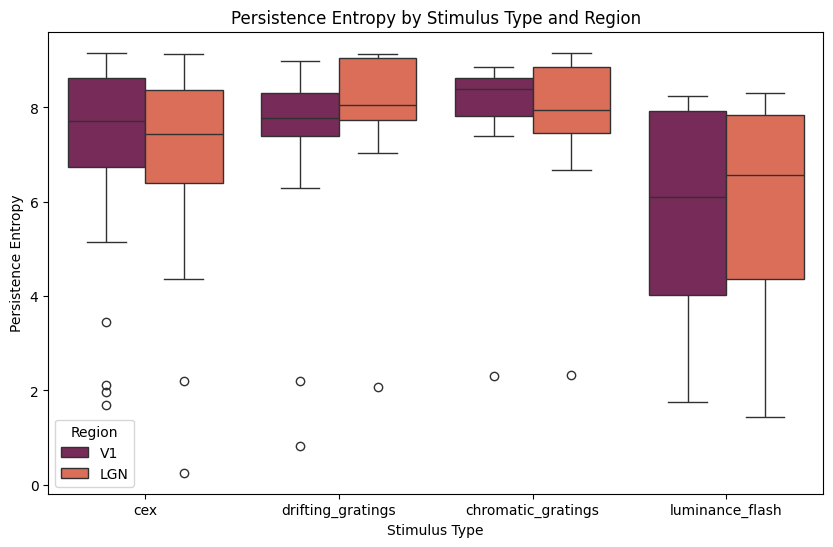

In [ ]:
# box plot for persistence entropy by stimulus type
plt.figure(figsize=(10, 6))
sns.boxplot(x="stim", y="persistence_entropy", hue="region", data=df, palette="rocket")
plt.title("Persistence Entropy by Stimulus Type and Region")
plt.xlabel("Stimulus Type")
plt.ylabel("Persistence Entropy")
plt.legend(title="Region")
plt.show()

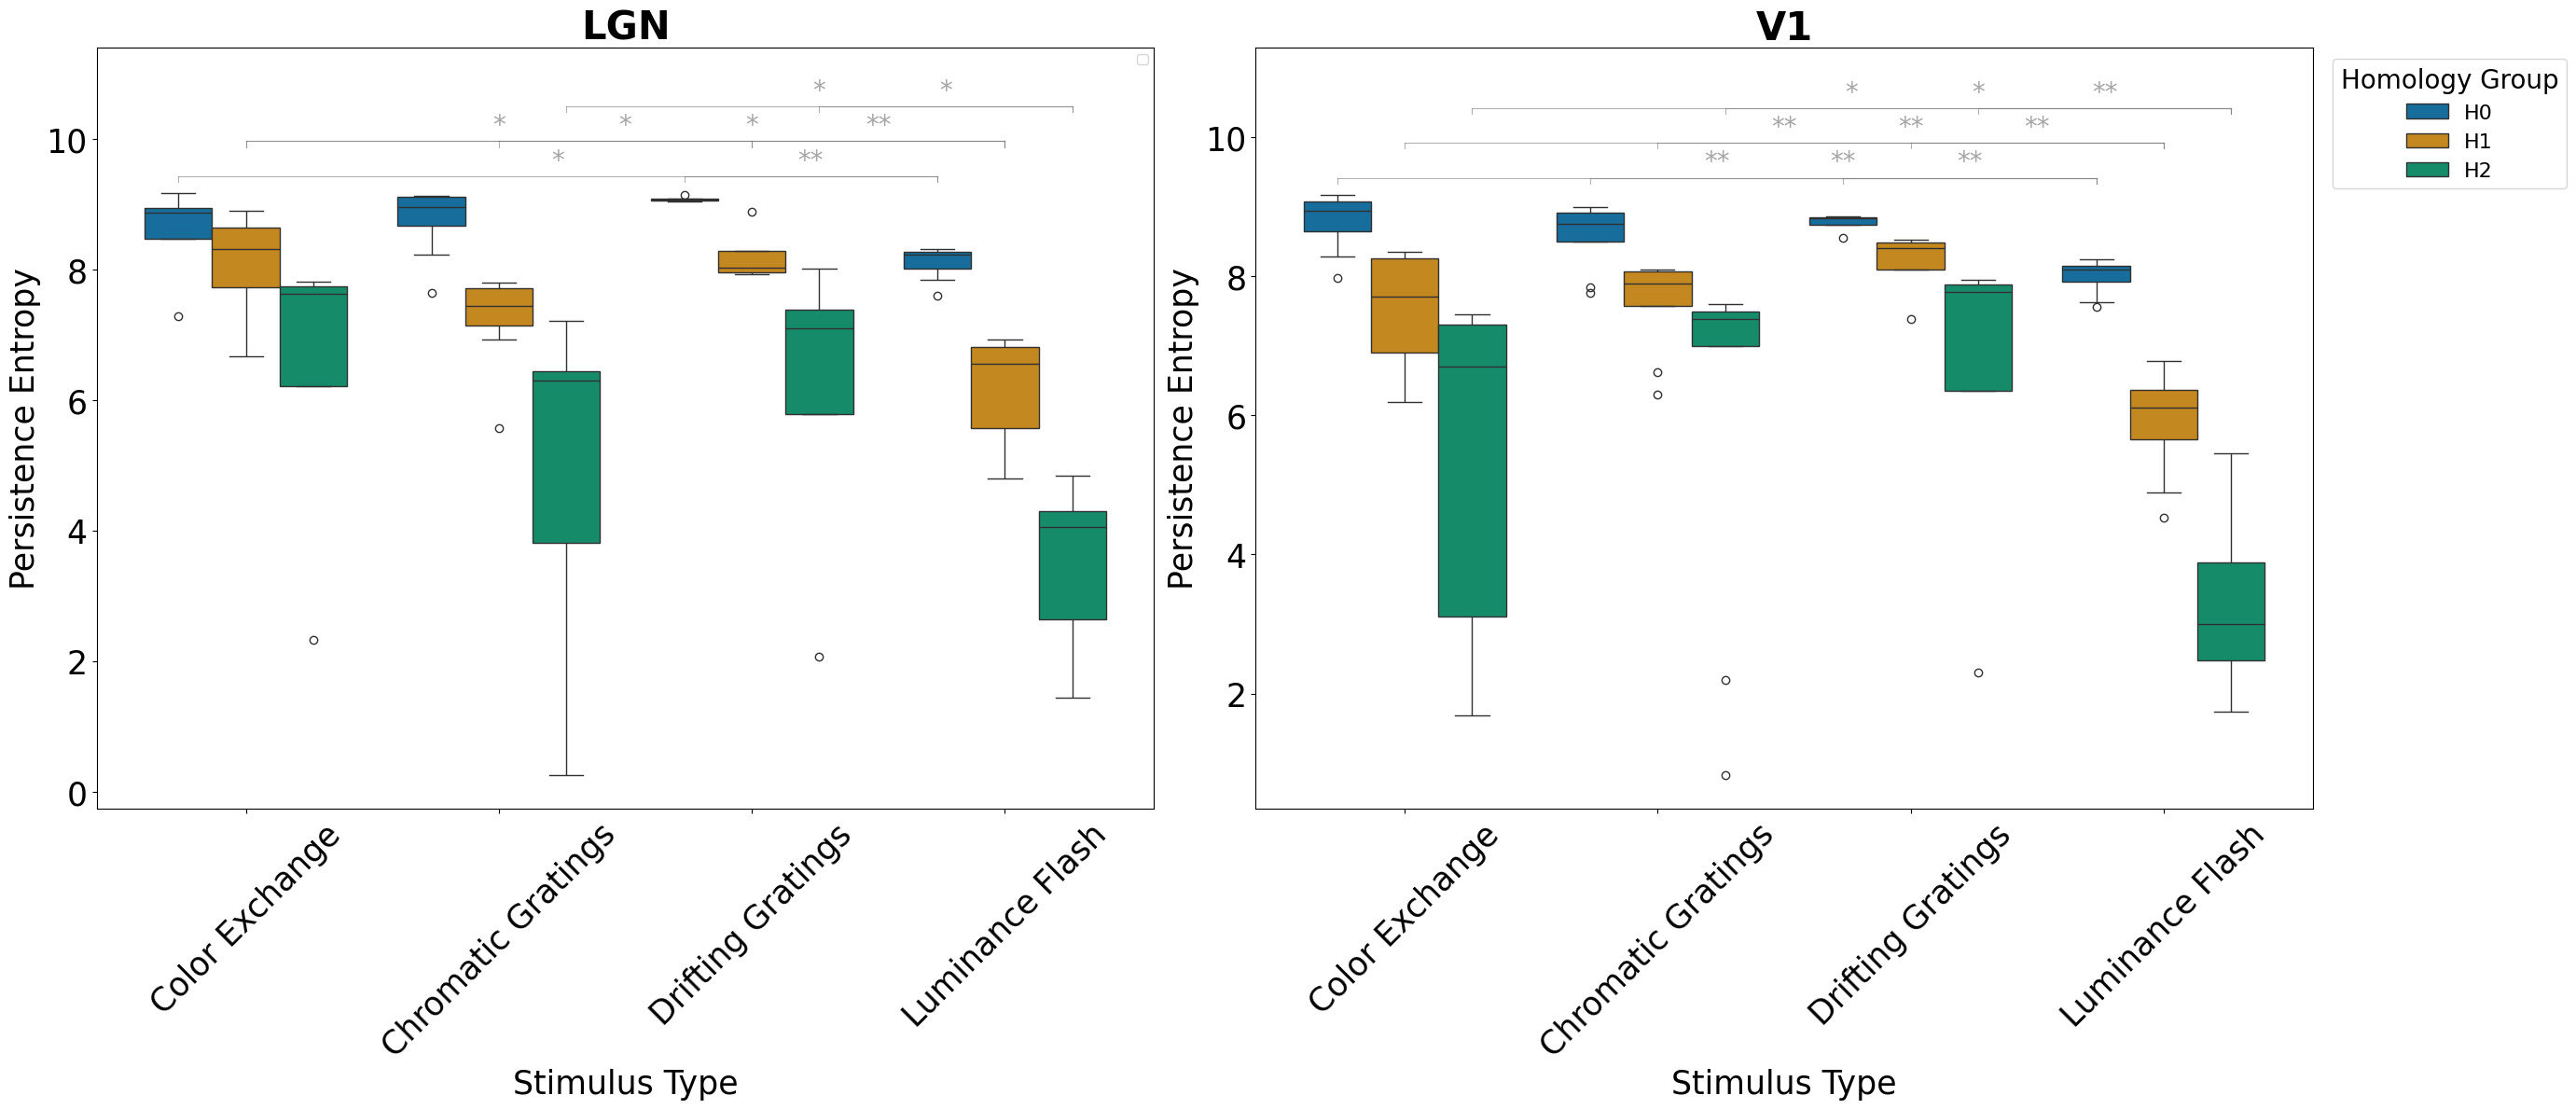

In [ ]:
# box plot for persistence entropy by homology group with significance values

def pairwise_perm_test(group1_data, group2_data, n_perm=999, random_state=0):
    """Perform permutation test between two groups
    
    Args:
        group1_data (np.ndarray): data for group 1
        group2_data (np.ndarray): data for group 2
        n_perm (int): number of permutations
        random_state (int): random seed
    
    Returns:
        float: p-value """

    rng = np.random.default_rng(random_state)
    obs_diff = np.mean(group1_data) - np.mean(group2_data)
    combined = np.concatenate([group1_data, group2_data])
    n1, n2 = len(group1_data), len(group2_data)
    
    count = 0
    for _ in range(n_perm):
        perm = rng.permutation(combined)
        perm_diff = np.mean(perm[:n1]) - np.mean(perm[n1:])
        if abs(perm_diff) >= abs(obs_diff):
            count += 1
    
    pval = (count + 1) / (n_perm + 1)
    return pval

# p-value to asterisks
def pval_to_asterisks(pval):
    """Convert p-value to asterisks
    
    Args:
        pval (float): p-value
    
    Returns:
        str: asterisks """

    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    elif pval < 0.1:
        return '†'
    else:
        return ''

#  two subplots for LGN and V1
fig, axes = plt.subplots(1, 2, figsize=(25, 12))
stimuli = ['Color Exchange', 'Chromatic Gratings', 'Drifting Gratings', 'Luminance Flash']
regions = ['LGN', 'V1']

# separate by region
all_sig_pairs = []

for region_idx, region in enumerate(regions):
    ax = axes[region_idx]
    
    # Filter by region
    df_region = df[df["region"] == region]
    
    # boxplot
    bp = sns.boxplot(x="stim", y="persistence_entropy", hue="homology", data=df_region, palette="colorblind", ax=ax)
    ax.set_title(f"{region}", fontsize=30, fontweight='bold')
    ax.set_xlabel("Stimulus Type", fontsize=25)
    ax.set_xticks(range(len(stimuli)), stimuli, fontsize=25, rotation=45)
    ax.set_ylabel("Persistence Entropy", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.legend([])
    
    # positions for significance bars
    stim_order = sorted(df_region["stim"].unique())
    homology_order = sorted(df_region["homology"].unique())
    n_stims = len(stim_order)
    n_homology = len(homology_order)
    
    # box positions from the plot patches
    box_positions = {}
    patches = [p for p in ax.patches if hasattr(p, 'get_x') and p.get_width() > 0]
    
    # use expected number of patches if available
    if len(patches) >= n_stims * n_homology:
        for patch_idx, patch in enumerate(patches[:n_stims * n_homology]):
            x_center = patch.get_x() + patch.get_width() / 2
            stim_idx = patch_idx // n_homology
            h_idx = patch_idx % n_homology
            
            if stim_idx < n_stims and h_idx < n_homology:
                stim = stim_order[stim_idx]
                h = homology_order[h_idx]
                box_positions[(stim, h)] = x_center
    else:
        # or calculate approximate positions
        for i, stim in enumerate(stim_order):
            for j, h in enumerate(homology_order):
                base_x = i
                hue_offset = (j - (n_homology - 1) / 2) * (0.8 / max(n_homology, 1))
                box_positions[(stim, h)] = base_x + hue_offset
    
    # calculate pairwise comparisons within each homology group for this region
    y_max = df_region["persistence_entropy"].max()
    y_min = df_region["persistence_entropy"].min()
    y_range = y_max - y_min
    bar_height = y_range * 0.03
    bar_spacing = y_range * 0.01
    
    # store significance pairs for annotation
    sig_pairs = []
    
    for h_idx, h in enumerate(homology_order):
        h_data = df_region[df_region["homology"] == h]
        
        # get unique stimuli for this homology group
        stims_in_h = sorted(h_data["stim"].unique())
        
        # pairwise comparisons
        for stim1, stim2 in combinations(stims_in_h, 2):
            stim1_data = h_data[h_data["stim"] == stim1]["persistence_entropy"].dropna().values
            stim2_data = h_data[h_data["stim"] == stim2]["persistence_entropy"].dropna().values
            
            if len(stim1_data) > 0 and len(stim2_data) > 0:
                #  permutation test
                pval = pairwise_perm_test(stim1_data, stim2_data, n_perm=999, random_state=0)
                
                # get x positions for these stimuli (using box positions for this homology group)
                if (stim1, h) in box_positions and (stim2, h) in box_positions:
                    x1 = box_positions[(stim1, h)]
                    x2 = box_positions[(stim2, h)]
                else:
                    continue  # Skip if no have positions
                
                # adjust y position based on homology group
                y_pos = y_max + (h_idx * (bar_height + bar_spacing) * 1.5) + bar_height
                
                # only show significant comparisons (p < 0.1)
                if pval < 0.1:
                    sig_pairs.append({
                        'x1': x1, 'x2': x2, 'y': y_pos, 'pval': pval, 
                        'homology': h, 'stim1': stim1, 'stim2': stim2, 'region': region
                    })
                    all_sig_pairs.append({
                        'x1': x1, 'x2': x2, 'y': y_pos, 'pval': pval, 
                        'homology': h, 'stim1': stim1, 'stim2': stim2, 'region': region
                    })
    
    # significance bars
    for pair in sig_pairs:
        x1, x2, y_pos = pair['x1'], pair['x2'], pair['y']
        pval = pair['pval']
        
        #  horizontal line 
        ax.plot([x1, x2], [y_pos, y_pos], 'gray', linewidth=0.8, alpha=0.6)
        
        # vertical lines at ends 
        ax.plot([x1, x1], [y_pos - bar_spacing, y_pos], 'gray', linewidth=0.8, alpha=0.6)
        ax.plot([x2, x2], [y_pos - bar_spacing, y_pos], 'gray', linewidth=0.8, alpha=0.6)
        
        #  asterisk annotation 
        mid_x = (x1 + x2) / 2
        asterisks = pval_to_asterisks(pval)
        if asterisks:
            ax.text(mid_x, y_pos + bar_spacing * 0.5, asterisks, ha='center', va='bottom', 
                    fontsize=20, color='gray', alpha=0.7)
    
    if sig_pairs:
        max_y = max(pair['y'] for pair in sig_pairs) + bar_height + bar_spacing
        ax.set_ylim(top=max_y * 1.05)

plt.tight_layout()
plt.legend(title = "Homology Group", loc='center right', bbox_to_anchor=(1.25, 0.9), fontsize=16, title_fontsize=20)
plt.show()

In [12]:
# permutation ANOVA for persistence feature numbers / betti numbers
import statsmodels.api as sm


n_feature_rows = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".pkl"):
        continue
    fpath = os.path.join(data_dir, fname)

    try:
        meta = parse_filename(fname)
    except ValueError as e:
        print(f"Skipping {fname}: {e}")
        continue

    dgms = load_dgms(fpath)

    # turn each homology group into a feature count
    # n_feature = number of intervals in that diagram
    for i, dgm in enumerate(dgms):
        homology_label = f"H{i}"
        if dgm is None:
            n_feature = 0
        else:
            n_feature = len(dgm)

        n_feature_rows.append({
            "file": fname,
            "region": meta["region"],
            "mouse": meta["mouse"],
            "stim": meta["stim"],
            "embed_dim": meta["embed_dim"],
            "homology": homology_label,
            "n_feature": n_feature,
        })

n_feature_df = pd.DataFrame(n_feature_rows).reset_index(drop=True)
print("n_feature DF preview:")
print(n_feature_df.head())
print("Shape:", n_feature_df.shape)

n_feature_formula = (
    "n_feature ~ C(region) + C(mouse) + C(stim) + C(embed_dim) + C(homology)"
)

n_feature_model = ols(n_feature_formula, data=n_feature_df).fit()
n_feature_anova = sm.stats.anova_lm(n_feature_model, typ=2)
print("\nANOVA on n_feature:")
print(n_feature_anova)

def permutation_anova_n_feature(df, formula, n_perm=999, random_state=0):
    """ Perform permutation ANOVA on the data
    
    Args:
        df (pd.DataFrame): dataframe containing the data
        formula (str): formula for the ANOVA
        n_perm (int): number of permutations
    Returns:
        pd.DataFrame: dataframe containing the permutation ANOVA results """

    rng = np.random.default_rng(random_state)

    base_model = ols(formula, data=df).fit()
    base_anova = sm.stats.anova_lm(base_model, typ=2)
    obs_F = base_anova["F"].to_dict()

    perm_F = {term: [] for term in obs_F if term != "Residual"}

    y = df["n_feature"].to_numpy().copy()

    for _ in range(n_perm):
        rng.shuffle(y)
        df_perm = df.copy()
        df_perm["n_feature"] = y
        m_perm = ols(formula, data=df_perm).fit()
        a_perm = sm.stats.anova_lm(m_perm, typ=2)
        for term in perm_F.keys():
            perm_F[term].append(a_perm.loc[term, "F"])

    out = base_anova.copy()
    out["perm_pval"] = np.nan
    for term, vals in perm_F.items():
        vals = np.asarray(vals)
        obs = obs_F[term]
        p = (np.sum(vals >= obs) + 1) / (len(vals) + 1)
        out.loc[term, "perm_pval"] = p

    return out

n_feature_perm_results = permutation_anova_n_feature(
    n_feature_df,
    n_feature_formula,
    n_perm=999,
    random_state=0
)

print("\nPermutation ANOVA on n_feature:")
print(n_feature_perm_results)


Skipping V1_32d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_32d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping V1_8d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_8d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping V1_3d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_3d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping dgms_random_null.pkl: Unexpected filename structure: dgms_random_null.pkl
Skipping V1_24d_shuffled_chromatic_gratings_C161_dgms.pkl: Unexpected filename structure: V1_24d_shuffled_chromatic_gratings_C161_dgms.pkl
Skipping random_model_ce.pkl: Unexpected filename structure: random_model_ce.pkl
Skipping categorical_model_ce.pkl: Unexpected filename structure: categorical_model_ce.pkl
Skipping dgms_categorical_null.pkl: Unexpected filename structure: dgms_categorical_null.pkl
n_feature DF preview:
                       file region mouse               stim embed_dim  \
0  CE

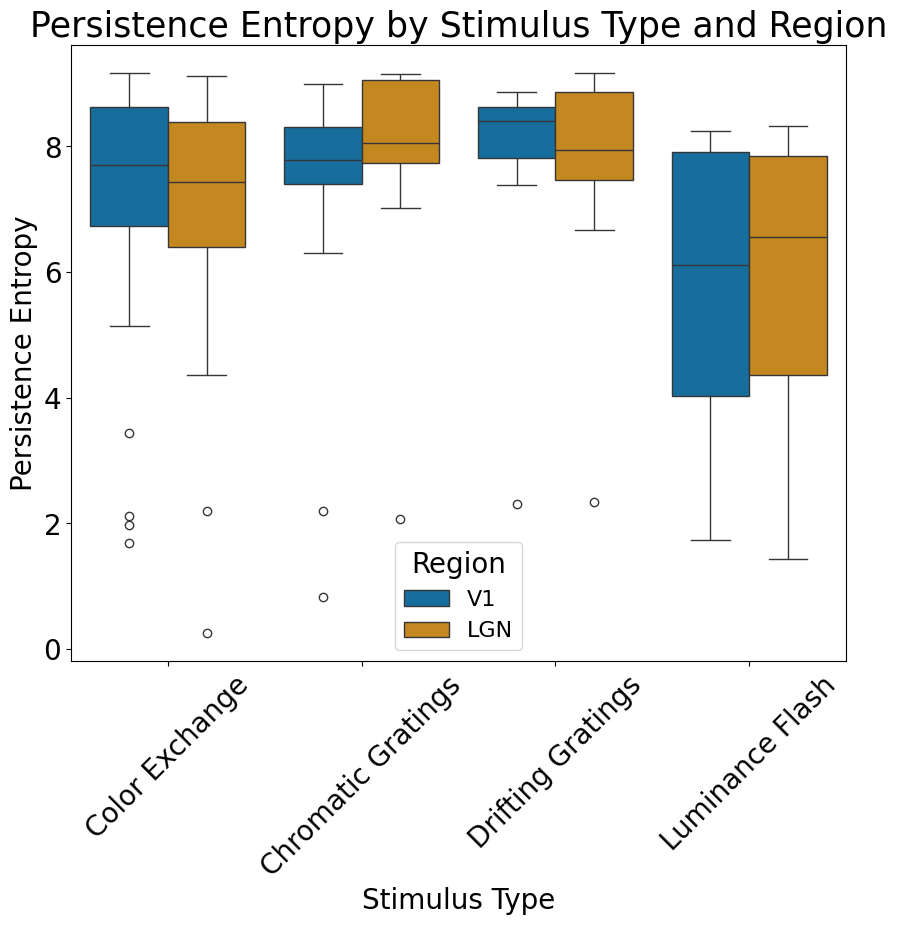

In [13]:
# boxpot for feature num by stimulus type
stimuli = ["Color Exchange", "Chromatic Gratings", "Drifting Gratings", "Luminance Flash"]
plt.figure(figsize=(10, 8))
sns.boxplot(x="stim", y="persistence_entropy", hue="region", data=df, palette="colorblind")
plt.title("Persistence Entropy by Stimulus Type and Region", fontsize=25)
plt.xlabel("Stimulus Type", fontsize=20)
plt.xticks(range(len(stimuli)), stimuli, fontsize=20, rotation=45)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel("Persistence Entropy", fontsize=20)
plt.legend(title="Region", fontsize=16, title_fontsize=20)
plt.show()

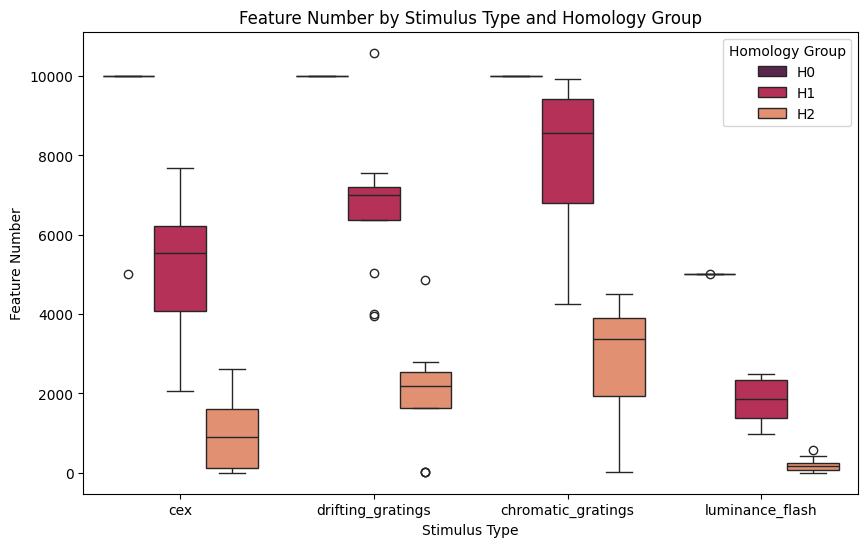

In [14]:
# boxplot for feature num by homology group
plt.figure(figsize=(10, 6))
sns.boxplot(x="stim", y="n_feature", hue="homology", data=n_feature_df, palette="rocket")  
plt.title("Feature Number by Stimulus Type and Homology Group")
plt.xlabel("Stimulus Type")
plt.ylabel("Feature Number")
plt.legend(title="Homology Group")
plt.show()

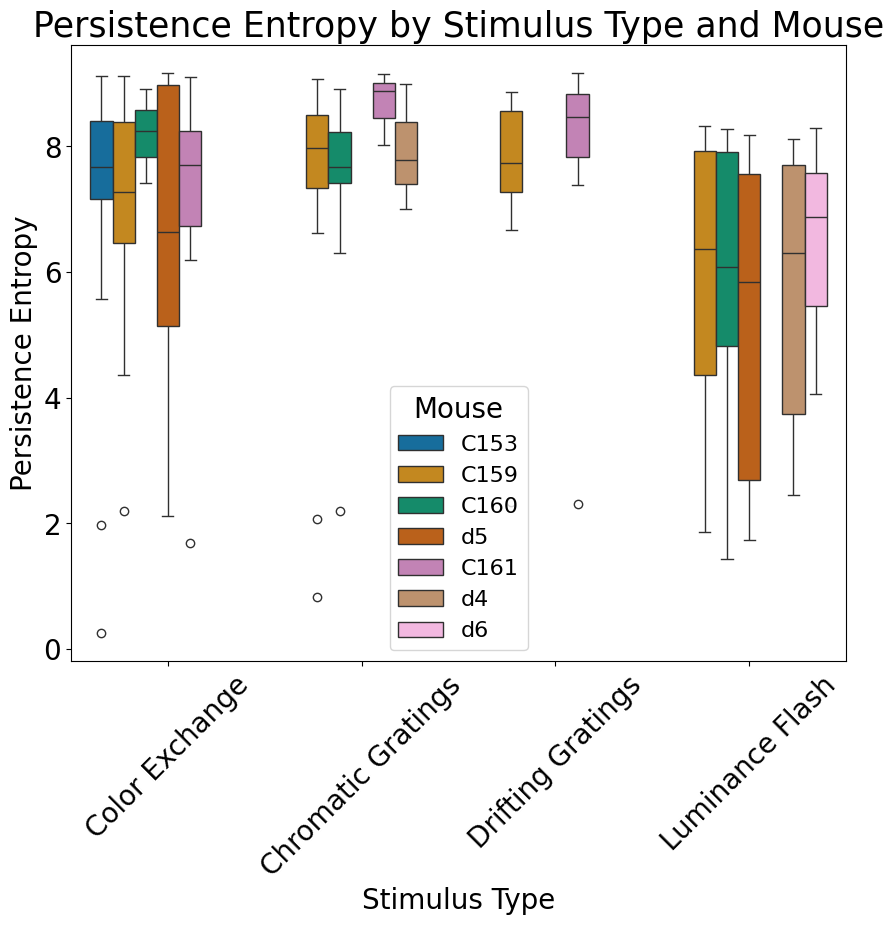

In [15]:
#box plot for n feature by mouse
stimuli = ["Color Exchange", "Chromatic Gratings", "Drifting Gratings", "Luminance Flash"]
plt.figure(figsize=(10,8))
sns.boxplot(x="stim", y="persistence_entropy", hue="mouse", data=df, palette="colorblind")  
plt.title("Persistence Entropy by Stimulus Type and Mouse", fontsize=25)
plt.xlabel("Stimulus Type", fontsize=20)
plt.xticks(range(len(stimuli)), stimuli, fontsize=20, rotation=45)
plt.ylabel("Persistence Entropy", fontsize=20)
plt.legend(title="Mouse", fontsize=16, title_fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

In [16]:
# small scale ANOVA
def two_group_perm_test(topo_metric, labels, n_perm=999, random_state=0):
    """ Perform permutation test between two groups
    
    Args:
        topo_metric (np.ndarray): 1D array of topo metric (persistence_entropy or n_feature)
        labels (np.ndarray): 1D array of group labels (LGN/V1)
        n_perm (int): number of permutations
    Returns:
        tuple: observed difference (label1 - label2), p-value """

    rng = np.random.default_rng(random_state)
    topo_metric = np.asarray(topo_metric)
    lebels = np.asarray(labels)

    groups = np.unique(labels)
    assert len(groups) == 2, "Only works for 2 groups"

    label1, label2 = groups
    obs = topo_metric[labels == label1].mean() - topo_metric[labels == label2].mean()

    count = 0
    for _ in range(n_perm):
        perm = rng.permutation(topo_metric)
        pdiff = perm[labels == label1].mean() - perm[labels == label2].mean()
        if abs(pdiff) >= abs(obs):
            count += 1

    pval = (count + 1) / (n_perm + 1)
    return obs, pval


In [17]:
# test single factors
df_sub = df[(df["homology"] == "H0") & (df["stim"] == "drifting_gratings")]

obs_diff, p = two_group_perm_test(
    df_sub["persistence_entropy"].values,
    df_sub["region"].values
)
print("obs diff (LGN - V1):", obs_diff)
print("perm p-value:", p)


obs diff (LGN - V1): 0.507292441399219
perm p-value: 0.046


In [18]:
# ok here is a table of results for al combinations of homology and stimulus
metric_col = "persistence_entropy"   # or "n_feature"

def two_group_perm_test(topo_metric, labels, n_perm=999, random_state=0):
    """ Perform permutation test between two groups

    Args:
        topo_metric (np.ndarray): 1D array of topo metric (persistence_entropy or n_feature)
        labels (np.ndarray): 1D array of group labels (LGN/V1)
        n_perm (int): number of permutations
        random_state (int): random seed
    Returns:
        tuple: label1, label2, observed difference (label1 - label2), p-value """

    rng = np.random.default_rng(random_state)

    groups = np.unique(labels)
    assert len(groups) == 2, f"Need 2 groups, got {groups}"

    label1, label2 = groups
    obs = topo_metric[labels == label1].mean() - topo_metric[labels == label2].mean()

    count = 0
    for _ in range(n_perm):
        perm = rng.permutation(topo_metric)
        pdiff = perm[labels == label1].mean() - perm[labels == label2].mean()
        if abs(pdiff) >= abs(obs):
            count += 1

    pval = (count + 1) / (n_perm + 1)
    return label1, label2, obs, pval

rows = []

# detect if homology column exists
has_homology = "homology" in df.columns

for stim in sorted(df["stim"].unique()):
    if has_homology:
        for h in sorted(df["homology"].unique()):
            sub = df[(df["stim"] == stim) & (df["homology"] == h)]
            # need both regions present
            if sub["region"].nunique() < 2:
                continue
            label1, label2, obs, p = two_group_perm_test(
                sub[metric_col].values,
                sub["region"].values,
                n_perm=999,
                random_state=0,
            )
            rows.append({
                "stim": stim,
                "homology": h,
                "metric": metric_col,
                "group1": label1,
                "group2": label2,
                "obs_diff_(g1-g2)": obs,
                "perm_pval": p,
                "n": len(sub),
            })

pval_table = pd.DataFrame(rows)

print(pval_table)


                  stim homology               metric group1 group2  \
0                  cex       H0  persistence_entropy    LGN     V1   
1                  cex       H1  persistence_entropy    LGN     V1   
2                  cex       H2  persistence_entropy    LGN     V1   
3   chromatic_gratings       H0  persistence_entropy    LGN     V1   
4   chromatic_gratings       H1  persistence_entropy    LGN     V1   
5   chromatic_gratings       H2  persistence_entropy    LGN     V1   
6    drifting_gratings       H0  persistence_entropy    LGN     V1   
7    drifting_gratings       H1  persistence_entropy    LGN     V1   
8    drifting_gratings       H2  persistence_entropy    LGN     V1   
9      luminance_flash       H0  persistence_entropy    LGN     V1   
10     luminance_flash       H1  persistence_entropy    LGN     V1   
11     luminance_flash       H2  persistence_entropy    LGN     V1   

    obs_diff_(g1-g2)  perm_pval   n  
0          -0.052690      0.803  20  
1          -0

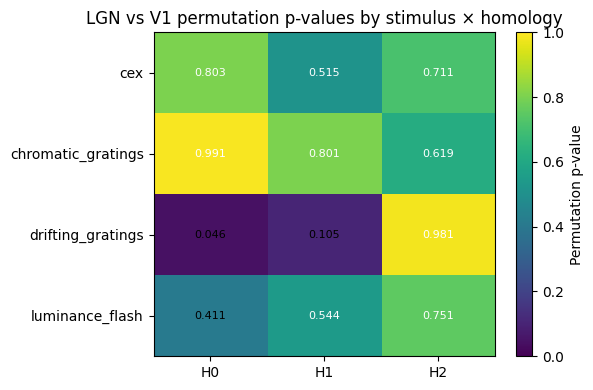

In [19]:
# with dimensions aggregated

heat_df = pval_table.pivot_table(
    index="stim",
    columns="homology",
    values="perm_pval"
)

fig, ax = plt.subplots(figsize=(6, 4))

# imshow will show NaN as blank; we can mask them
im = ax.imshow(heat_df.values, aspect="auto", cmap="viridis", vmin=0, vmax=1)

# axis labels
ax.set_xticks(np.arange(len(heat_df.columns)))
ax.set_xticklabels(heat_df.columns)
ax.set_yticks(np.arange(len(heat_df.index)))
ax.set_yticklabels(heat_df.index)

# annotate cells with p-values
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        val = heat_df.values[i, j]
        if not np.isnan(val):
            ax.text(
                j, i, f"{val:.3f}",
                ha="center", va="center",
                color="white" if val > 0.5 else "black",
                fontsize=8
            )

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Permutation p-value")

ax.set_title("LGN vs V1 permutation p-values by stimulus × homology")
plt.tight_layout()
plt.show()


In [ ]:
#  now include dimension of embeddings

metric_col = "persistence_entropy"   # or "n_feature"

rows = []

for stim in sorted(df["stim"].unique()):
    for dim in sorted(df["embed_dim"].unique()):
        sub = df[(df["stim"] == stim) & (df["embed_dim"] == dim)]
        if sub["region"].nunique() < 2:
            continue
        g1, g2, obs, p = two_group_perm_test(
            sub[metric_col].values,
            sub["region"].values,
            n_perm=999,
            random_state=0,
        )
        rows.append({
            "stim": stim,
            "embed_dim": dim,
            "metric": metric_col,
            "group1": g1,
            "group2": g2,
            "obs_diff_(g1-g2)": obs,
            "perm_pval": p,
            "n": len(sub),
        })

pval_table = pd.DataFrame(rows)

print(pval_table)


                  stim embed_dim               metric group1 group2  \
0                  cex       24d  persistence_entropy    LGN     V1   
1                  cex       32d  persistence_entropy    LGN     V1   
2                  cex        3d  persistence_entropy    LGN     V1   
3                  cex        8d  persistence_entropy    LGN     V1   
4   chromatic_gratings       24d  persistence_entropy    LGN     V1   
5   chromatic_gratings       32d  persistence_entropy    LGN     V1   
6   chromatic_gratings        3d  persistence_entropy    LGN     V1   
7   chromatic_gratings        8d  persistence_entropy    LGN     V1   
8    drifting_gratings       24d  persistence_entropy    LGN     V1   
9    drifting_gratings       32d  persistence_entropy    LGN     V1   
10   drifting_gratings        3d  persistence_entropy    LGN     V1   
11   drifting_gratings        8d  persistence_entropy    LGN     V1   
12     luminance_flash       24d  persistence_entropy    LGN     V1   
13    

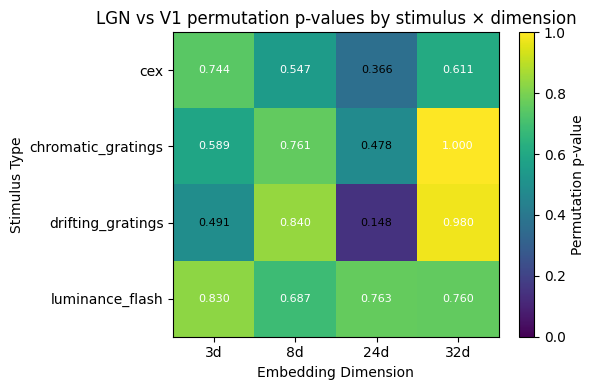

embed_dim              3d     8d    24d    32d
stim                                          
cex                 0.744  0.547  0.366  0.611
chromatic_gratings  0.589  0.761  0.478  1.000
drifting_gratings   0.491  0.840  0.148  0.980
luminance_flash     0.830  0.687  0.763  0.760


In [21]:

dim_order = ['3d', '8d', '24d', '32d']

heat_df_dim = pval_table.pivot_table(
    index="stim",
    columns="embed_dim",
    values="perm_pval"
)


heat_df_dim = heat_df_dim.reindex(columns=dim_order)

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(heat_df_dim.values, aspect="auto", cmap="viridis", vmin=0, vmax=1)

# Set axis labels with proper ordering
ax.set_xticks(np.arange(len(heat_df_dim.columns)))
ax.set_xticklabels(heat_df_dim.columns)
ax.set_yticks(np.arange(len(heat_df_dim.index)))
ax.set_yticklabels(heat_df_dim.index)


for i in range(heat_df_dim.shape[0]):
    for j in range(heat_df_dim.shape[1]):
        val = heat_df_dim.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.3f}",
                    ha="center", va="center",
                    color="white" if val > 0.5 else "black",
                    fontsize=8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Permutation p-value")
ax.set_title("LGN vs V1 permutation p-values by stimulus × dimension")
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Stimulus Type")
plt.tight_layout()
plt.show()

print(heat_df_dim)

In [ ]:
# one way permutation ANOVA on embedding dimension (pooling regions together) 

rows = []

for stim in sorted(df["stim"].unique()):
    # Pool regions together 
    sub = df[df["stim"] == stim]

    if sub["embed_dim"].nunique() < 2:
        continue
    
    formula = f"{metric_col} ~ C(embed_dim)"
    
    perm_results = permutation_anova(sub, formula, n_perm=999, random_state=0)
    
    if "C(embed_dim)" in perm_results.index:
        embed_dim_result = perm_results.loc["C(embed_dim)"]
        rows.append({
            "stim": stim,
            "metric": metric_col,
            "factor": "embed_dim",
            "F_statistic": embed_dim_result["F"],
            "perm_pval": embed_dim_result["perm_pval"],
            "n": len(sub),
            "n_dims": sub["embed_dim"].nunique(),
            "dims": sorted(sub["embed_dim"].unique()),
        })

pval_table_dim = pd.DataFrame(rows)

print(pval_table_dim)




                 stim               metric     factor  F_statistic  perm_pval  \
0                 cex  persistence_entropy  embed_dim     4.742328      0.005   
1  chromatic_gratings  persistence_entropy  embed_dim     4.964621      0.004   
2   drifting_gratings  persistence_entropy  embed_dim     5.642469      0.003   
3     luminance_flash  persistence_entropy  embed_dim     0.997755      0.407   

    n  n_dims                dims  
0  60       4  [24d, 32d, 3d, 8d]  
1  24       4  [24d, 32d, 3d, 8d]  
2  39       4  [24d, 32d, 3d, 8d]  
3  57       4  [24d, 32d, 3d, 8d]  


In [ ]:
# Heatmap for mean Wasserstein distances BETWEEN stimulus types for all 3 homology groups (3d only) - extremely slow
import seaborn as sns
import matplotlib.pyplot as plt
from persim import wasserstein
from itertools import combinations

embed_dim = "3d"  # only 3d embeddings

# Load all diagrams and store metadata for all homology groups
diagram_records = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".pkl"):
        continue
    
    fpath = os.path.join(data_dir, fname)
    
    try:
        meta = parse_filename(fname)
    except ValueError as e:
        continue
    
    # Filter to only 3d embeddings
    if meta["embed_dim"] != embed_dim:
        continue
    
    try:
        dgms = load_dgms(fpath)
    except Exception as e:
        continue
    
    if dgms is None or len(dgms) < 3:
        continue
    
    # Store all homology groups
    for h_idx in range(3):  # H0, H1, H2
        if len(dgms) > h_idx:
            dgm = dgms[h_idx]
            if dgm is not None and len(dgm) > 0:
                diagram_records.append({
                    "file": fname,
                    "region": meta["region"],
                    "stim": meta["stim"],
                    "embed_dim": meta["embed_dim"],
                    "mouse": meta["mouse"],
                    "homology": f"H{h_idx}",
                    "dgm": dgm
                })

diagram_df = pd.DataFrame(diagram_records)

#check your files
print(f"Loaded {len(diagram_df)} diagrams for {embed_dim} embeddings")
print(f"Stimuli: {sorted(diagram_df['stim'].unique())}")
print(f"Homology groups: {sorted(diagram_df['homology'].unique())}")

# Compute mean Wasserstein distances BETWEEN stimulus types for each homology group
for homology in ['H0', 'H1', 'H2']:
    
    h_df = diagram_df[diagram_df["homology"] == homology]
    
    if len(h_df) == 0:
        print(f"No diagrams found for {homology}")
        continue
    
    stimuli = sorted(h_df["stim"].unique())
    
    # Compute distances between all pairs of stimulus types
    mean_distances = []
    
    for stim1, stim2 in combinations(stimuli, 2):
        group1 = h_df[h_df["stim"] == stim1]["dgm"].tolist()
        group2 = h_df[h_df["stim"] == stim2]["dgm"].tolist()
        
        if len(group1) == 0 or len(group2) == 0:
            continue
        
        # Compute all pairwise distances between the two stimulus groups
        distances = []
        for dgm1 in group1:
            for dgm2 in group2:
                try:
                    dist = wasserstein(dgm1, dgm2, matching=False)
                    distances.append(dist)
                except Exception as e:
                    continue
        
        if len(distances) > 0:
            mean_dist = np.mean(distances)
            mean_distances.append({
                "stim1": stim1,
                "stim2": stim2,
                "mean_wasserstein": mean_dist,
                "n_pairs": len(distances)
            })
    
    # create symmetric matrix for heatmap
    stim_list = sorted(stimuli)
    n_stims = len(stim_list)
    dist_matrix = np.full((n_stims, n_stims), np.nan)
    
    for dist_info in mean_distances:
        i = stim_list.index(dist_info["stim1"])
        j = stim_list.index(dist_info["stim2"])
        dist_matrix[i, j] = dist_info["mean_wasserstein"]
        dist_matrix[j, i] = dist_info["mean_wasserstein"]  # Make symmetric
    
    # set diagonal to 0 
    np.fill_diagonal(dist_matrix, 0)
    
    # create heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # DataFrame for labeling
    heatmap_df = pd.DataFrame(dist_matrix, index=stim_list, columns=stim_list)
    
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        cbar_kws={"label": f"Mean Wasserstein Distance ({homology})"},
        ax=ax,
        linewidths=0.5,
        linecolor="gray",
        square=True
    )
    
    ax.set_title(f"Mean Wasserstein Distances Between Stimulus Types ({homology}, {embed_dim})")
    ax.set_xlabel("Stimulus Type")
    ax.set_ylabel("Stimulus Type")
    plt.tight_layout()
    plt.show()
    
    print(f"Heatmap created for {homology}")
    print(f"Distance matrix:\n{heatmap_df}")


Loaded 45 diagrams for 3d embeddings
Stimuli: ['cex', 'chromatic_gratings', 'drifting_gratings', 'luminance_flash']
Homology groups: ['H0', 'H1', 'H2']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warni

In [ ]:
# omnibus permutation test


metric_col = "n_feature"   # or "persistence_entropy"
homology   = "H2"      # or None to pool
n_perm     = 999
seed       = 0

def _oneway_perm(y, g, n=999, seed=0):
    rng = np.random.default_rng(seed)
    y, g = np.asarray(y), np.asarray(g)
    lev = np.unique(g)
    def _ssb(vals):
        gm = vals.mean()
        return sum(((vals[g==L].mean()-gm)**2)*(g==L).sum() for L in lev)
    ssb_obs = _ssb(y)
    perm = np.empty(n)
    for i in range(n):
        yp = rng.permutation(y)
        perm[i] = _ssb(yp)
    p = (np.sum(perm >= ssb_obs) + 1) / (n + 1)
    return ssb_obs, p

def _pair_perm(y, g, a, b, n=999, seed=0):
    rng = np.random.default_rng(seed)
    m = (g==a)|(g==b); x, gg = np.asarray(y)[m], np.asarray(g)[m]
    d_obs = x[gg==a].mean() - x[gg==b].mean()
    cnt = 0
    for _ in range(n):
        xp = rng.permutation(x)
        d = xp[gg==a].mean() - xp[gg==b].mean()
        cnt += (abs(d) >= abs(d_obs))
    p = (cnt + 1) / (n + 1)
    return d_obs, p

# get correct df
if metric_col == "n_feature":
    data_df = n_feature_df
else:
    data_df = df

sub = data_df.copy()
if homology_entropies and "homology" in sub.columns:
    sub = sub[sub["homology"] == homology]
sub = sub.dropna(subset=[metric_col, "embed_dim"])

y = sub[metric_col].to_numpy()
g = sub["embed_dim"].to_numpy()

_, p_omni = _oneway_perm(y, g, n_perm, seed)
print("Omnibus permutation p (embed_dim):", p_omni)

dims = sorted(sub["embed_dim"].unique())
rows = []
for i in range(len(dims)):
    for j in range(i+1, len(dims)):
        d1, d2 = dims[i], dims[j]
        diff, p = _pair_perm(y, g, d1, d2, n_perm, seed)
        rows.append({"dim1": d1, "dim2": d2, "obs_diff(d1-d2)": diff, "p": p})

pairwise = pd.DataFrame(rows)
if not pairwise.empty:
    pairwise["p_fdr_bh"] = multipletests(pairwise["p"].values, method="fdr_bh")[1]
print(pairwise)


Omnibus permutation p (embed_dim): 0.003
  dim1 dim2  obs_diff(d1-d2)      p  p_fdr_bh
0  24d  32d       234.966667  0.626    0.7512
1  24d   3d      1728.500000  0.001    0.0020
2  24d   8d       385.785714  0.462    0.6930
3  32d   3d      1493.533333  0.001    0.0020
4  32d   8d       150.819048  0.765    0.7650
5   3d   8d     -1342.714286  0.001    0.0020
